In [ ]:
! pip install -q fiona geopandas osmnx # (or install using conda)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## 1. Чтение данных

In [2]:
from pathlib import Path

import pandas as pd

In [3]:
data_path = Path('final-etarta')

In [4]:
train = pd.read_csv(data_path / 'train.csv')
valid = pd.read_csv(data_path / 'validation.csv')
test = pd.read_csv(data_path / 'test.csv')

In [5]:
train.shape

(832718, 23)

In [6]:
train.head()

,Id,main_id_locality,ETA,RTA,OrderedDate,latitude,del_latitude,longitude,del_longitude,EDA,...,GoodArrived,ready_latitude,ready_longitude,onway_latitude,onway_longitude,arrived_latitude,arrived_longitude,center_latitude,center_longitude,route
0,0,1078,226.0,188.0,2020-02-12 19:12:06,55.826019,55.825581,49.134529,49.126949,1.0,...,2020-02-12 19:18:14,55.825647,49.134115,55.826261,49.134137,55.825706,49.127136,55.794388,49.111531,gnvsIaq{jHChA??uC???OPG^F^NRzKBd@AN[r@???`@`@`...
1,1,1078,718.0,725.0,2020-02-12 19:12:22,55.795502,55.820911,49.131470,49.115360,5.0,...,2020-02-12 19:31:47,55.795591,49.132281,55.795544,49.131552,55.821531,49.115685,55.794388,49.111531,sqpsI}~zjHyAr]e@lMk@fLaBlb@i@rLKhBCdAUxEGlCg@f...
2,2,1078,612.0,764.0,2020-02-12 19:12:44,55.791050,55.819962,49.226070,49.176628,5.0,...,2020-02-12 19:28:09,55.791099,49.226066,55.791099,49.226066,55.819765,49.177432,55.794388,49.111531,auosI}mmkH?LHd@KhC??o@w@[g@m@iAUk@??{G|OiB`Ek@...
3,3,1078,1560.0,1412.0,2020-02-12 19:12:44,55.753899,55.824680,49.188519,49.093700,13.0,...,2020-02-12 19:42:41,55.754116,49.188853,55.754116,49.188853,55.824734,49.094013,55.794388,49.111531,{lhsIiffkHmKN_C?mIPwMJ??Si@gA{B??Wq@MRCJTp@hAd...
4,4,1078,1528.0,893.0,2020-02-12 19:12:45,55.822361,55.786758,49.069092,49.143501,9.0,...,2020-02-12 19:32:19,55.822483,49.069659,55.822617,49.069229,55.786936,49.143330,55.794388,49.111531,yxusI{xnjHgAfG??}IuHkAqA??pIoe@VsA??dAkG`BuH??...


## 2. EDA
Можно запустить `pandas-profiling` посмотреть 

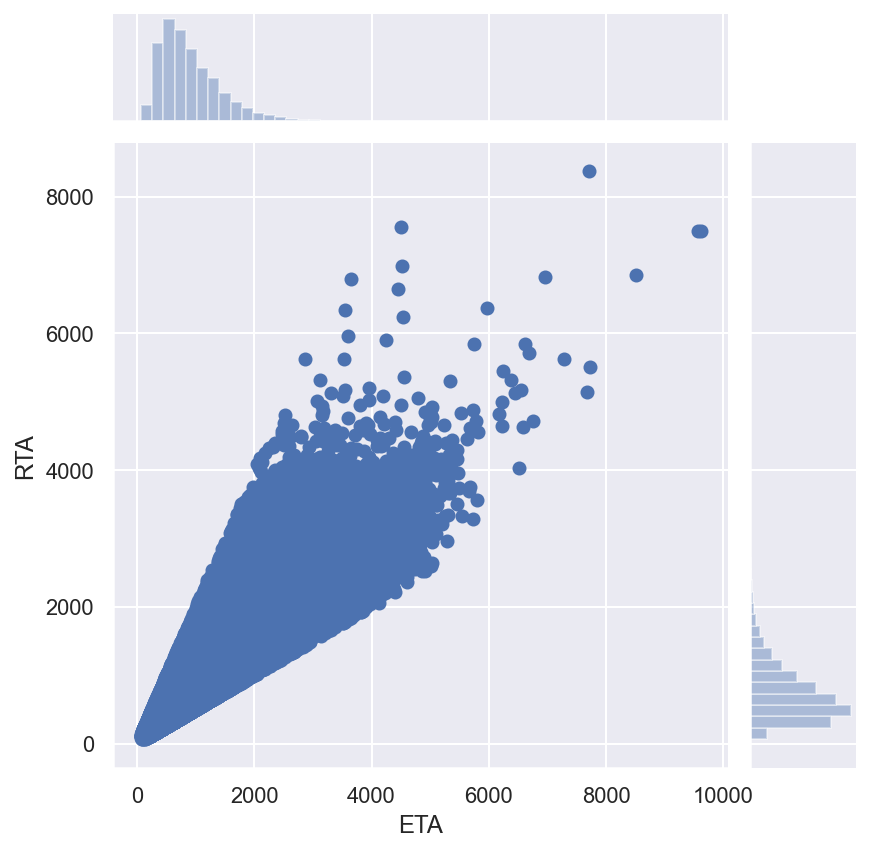

In [7]:
sns.jointplot(x="ETA", y="RTA", data=train)

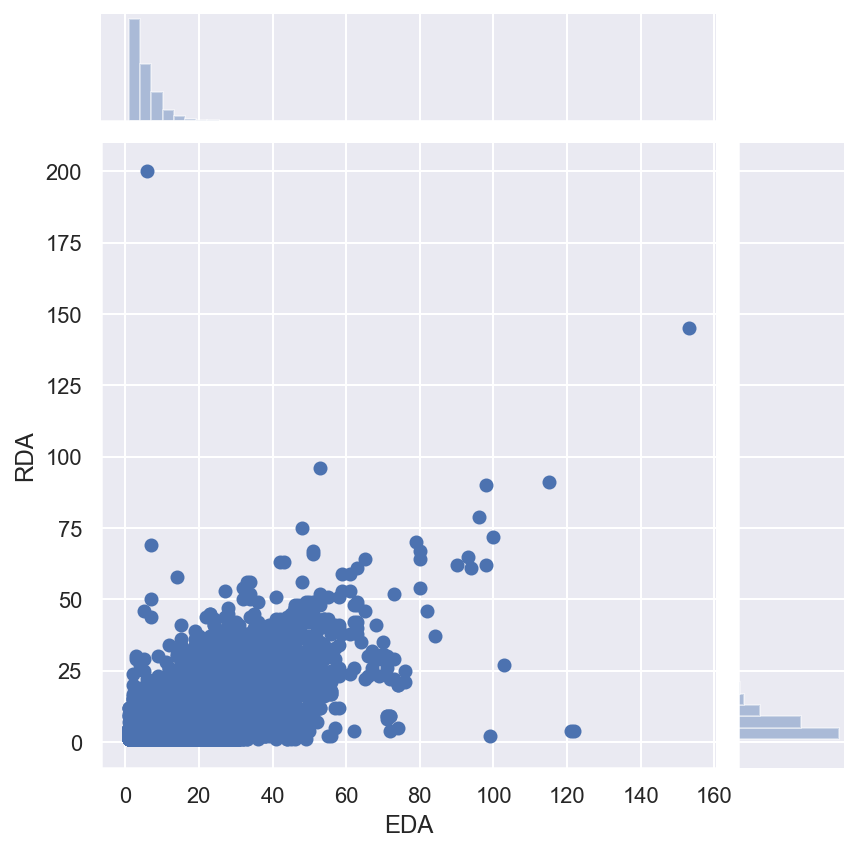

In [8]:
sns.jointplot(x="EDA", y="RDA", data=train)

Очень и очень четко видны выбросы, которые могут подпортить качество модели

Посмотрим насколько сильно ошибается текущая модель

In [9]:
train.groupby(by='main_id_locality').apply(lambda x: (x['ETA'] - x['RTA']).describe())

,count,mean,std,min,25%,50%,75%,max
main_id_locality,,,,,,,,
1078,312528.0,177.698353,222.934094,-2474.0,48.0,160.0,296.0,2119.0
22390,182536.0,80.433290,209.996653,-2200.0,-21.0,75.0,182.0,2542.0
22430,135563.0,161.315536,200.832095,-3156.0,46.0,138.0,255.0,2451.0
22438,202091.0,212.489725,256.604091,-2804.0,61.0,174.0,329.0,2396.0


Разница в 2200 секунд - однозначно выброс (скорее всего отменился какой-то заказ)

In [10]:
train.groupby(by='main_id_locality').apply(lambda x: (x['EDA'] - x['RDA']).describe())

,count,mean,std,min,25%,50%,75%,max
main_id_locality,,,,,,,,
1078,312528.0,0.471468,2.637179,-43.0,0.0,0.0,1.0,43.0
22390,182536.0,0.340919,2.203042,-194.0,0.0,0.0,0.0,118.0
22430,135563.0,0.421450,2.029351,-44.0,0.0,0.0,1.0,69.0
22438,202091.0,1.114191,3.748445,-62.0,0.0,0.0,1.0,97.0


Разница в 194 километра!

## 3. Чистка данных

In [11]:
import numpy as np
from scipy import stats

Лучше всего себя показал подход основанный на выкидывании по `z-score`.   
Существуют два варианта:
* вычислять выбросы по всему датасету
* вычислять выбросы по каждому городу в отдельности  
Второй подход выглядит предпочтительней

In [12]:
train = train.groupby(by='main_id_locality') \
    .apply(lambda x: x[(np.abs(stats.zscore(x['ETA'] - x['RTA'])) <= 3) & (np.abs(stats.zscore(x['EDA'] - x['RDA'])) <= 3)]) \
    .reset_index(drop=True)

In [13]:
train.shape

(803180, 23)

Итого оставили 803180 / 832718 ≈ 0.96 всех данных

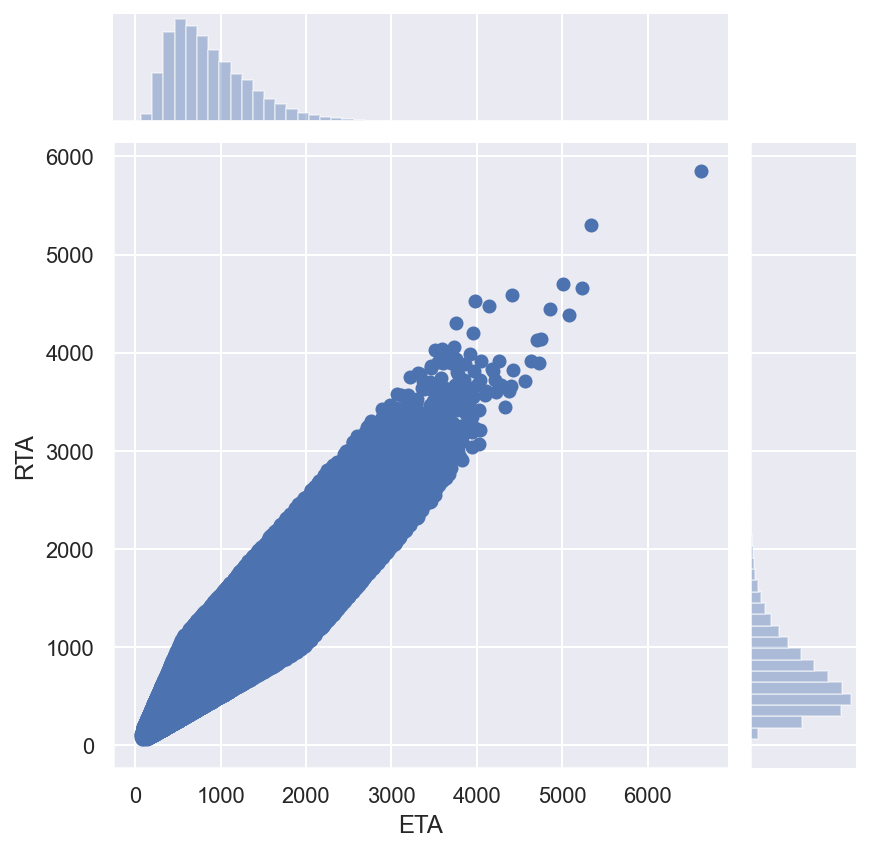

In [14]:
sns.jointplot(x="ETA", y="RTA", data=train)

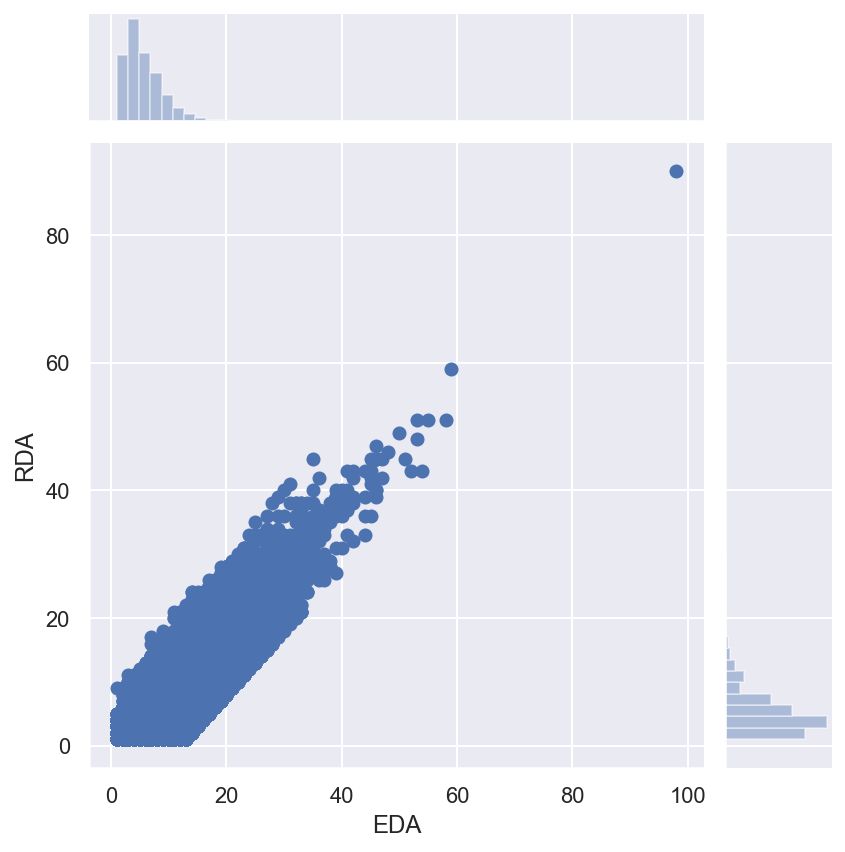

In [15]:
sns.jointplot(x="EDA", y="RDA", data=train)

Стало **куда лучше**

# **Feature engineering**
Для начала поймем какие города в выборке, и найдем местное время относительно Москвы

In [16]:
pd.DataFrame.from_records(zip(train['main_id_locality'].unique(), train['center_latitude'].unique(), train['center_longitude'].unique()), columns=['id', 'lat', 'lon'])

,id,lat,lon
0,1078,55.794388,49.111531
1,22390,53.183330,50.116670
2,22430,51.530376,45.953026
3,22438,58.010321,56.234178


Эти города это:
* 1078 - Казань/Kazan - +0 мск
* 22390 - Самара/Samara - +1 мск
* 22430 - Саратов/Saratov - +1 мск
* 22438 - Пермь/Perm - +2 мск

In [17]:
city_offset = {
    1078: 0,
    22390: 1,
    22430: 1,
    22438: 2
}

## 4. Фичи про **время**

In [18]:
def time_preprocessing(df):
    df['OrderedDate'] = pd.to_datetime(df['OrderedDate'])
    df['OrderedDate'] += pd.to_timedelta(df['main_id_locality'].apply(lambda x: city_offset[x]), unit='h')
    
    df['day_of_week'] = df['OrderedDate'].dt.day_name()
    df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday'])

    df['hour'] = df['OrderedDate'].dt.hour
    df['is_rush_hour'] = df['hour'].between(8, 12) | df['hour'].between(17, 19)
    df['is_night'] = df['hour'].between(22, 24) | df['hour'].between(0, 7)

    return df

In [19]:
train = time_preprocessing(train)
valid = time_preprocessing(valid)
test = time_preprocessing(test)

## 5. Фичи про **маршрут**

In [22]:
import geohash
from geopy import distance
from tqdm.autonotebook import tqdm
tqdm.pandas()

In [23]:
def degree_direction(start_lat, start_lng, end_lat, end_lng):
    """get direction of route (in degrees)"""
    AVG_EARTH_RADIUS = 6371 #km
    lng_delta_rad = np.radians(end_lng - start_lng)
    start_lat, start_lat, end_lat, end_lng = map(np.radians, (start_lat, start_lat, end_lat, end_lng))
    y = np.sin(lng_delta_rad) * np.cos(end_lng)
    x = np.cos(start_lat) * np.sin(end_lng) - np.sin(start_lat) * np.cos(end_lng) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [24]:
def route_geo_preprocessing(df):
    """
    считаем различные фичи:
        * расстояние между конечными и начальными точками маршрута
        * величина «объезда» — разница между предполагаемой длинной маршрута и путем напрямую
        * разница по широте/долготе
        * средние координаты маршрута
        * насколько далеко средние координаты маршрута от центра
        * угол маршрута в градусах
        * кластер точки начала маршрута
        * кластер точки конца маршрута
    """
    df['distance'] = df.progress_apply(lambda x: distance.distance((x['latitude'], x['longitude']), (x['del_latitude'], x['del_longitude'])).km, axis=1)
    df['detour'] = df['EDA'] - df['distance']    
    df['latitude_diff'] = (df['del_latitude'] - df['latitude']).abs()
    df['longitude_diff'] = (df['del_longitude'] - df['longitude']).abs()
    df['latitude_center'] = (df['del_latitude'] + df['latitude']) / 2
    df['longitude_center'] = (df['del_longitude'] + df['longitude']) / 2
    df['how_far_from_center'] = df.apply(lambda x: distance.distance((x['latitude_center'], x['longitude_center']), (x['center_latitude'], x['center_longitude'])).km, axis=1)
    df['direction'] = df.apply(lambda x: degree_direction(x['latitude'], x['longitude'], x['del_latitude'], x['del_longitude']), axis=1)
    df['pickup_hash'] = df.apply(lambda x: geohash.encode(x['latitude'], x['longitude'], precision=5), axis=1)
    df['del_hash'] = df.apply(lambda x: geohash.encode(x['del_latitude'], x['del_longitude'], precision=5), axis=1)
    return df

In [25]:
train = route_geo_preprocessing(train)
valid = route_geo_preprocessing(valid)
test = route_geo_preprocessing(test)

## 6. Фичи про ошибку модели в каждом городе

In [26]:
train_time_diff = pd.DataFrame(train.groupby(by='main_id_locality').apply(lambda x: (x['ETA'] - x['RTA']).mean()), columns=['time_diff']).reset_index()
train_time_diff

,main_id_locality,time_diff
0,1078,171.399381
1,22390,78.184118
2,22430,155.030171
3,22438,194.684379


In [27]:
train_dist_diff = pd.DataFrame(train.groupby(by='main_id_locality').apply(lambda x: (x['EDA'] - x['RDA']).mean()), columns=['distance_diff']).reset_index()
train_dist_diff

,main_id_locality,distance_diff
0,1078,0.111761
1,22390,0.117156
2,22430,0.235388
3,22438,0.483684


In [28]:
def diff_preprocessing(df):
    df = df.merge(train_time_diff)
    df = df.merge(train_dist_diff)
    return df

In [29]:
train = diff_preprocessing(train)
valid = diff_preprocessing(valid)
test = diff_preprocessing(test)

## 7. Фичи про **город** (~Embedding)
Каждый город чем-то уникален, в каждом городе **разная** ошибка. Чтобы не тренировать по модели на каждый город, давайте сгенерируем как можно больше признаков про каждый город. Будем делать это при помощи данных OpenStreetMap, а также представлением города в виде графа 

In [30]:
import numbers
import osmnx as ox

Пример:

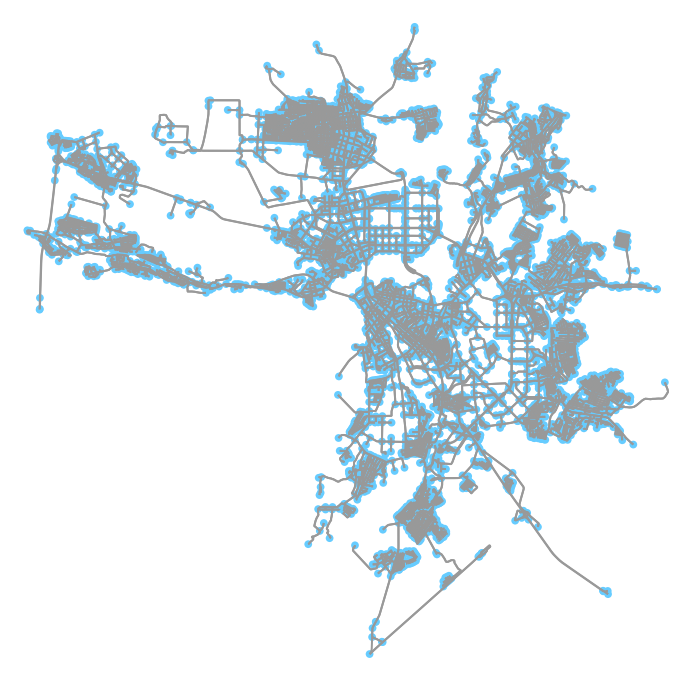

(<Figure size 784.708x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e69b7792c8>)

In [31]:
place = 'Kazan, Russia'
G = ox.graph_from_place(place, network_type='drive')
gdf = ox.gdf_from_place(place)
area = ox.project_gdf(gdf).unary_union.area
ox.plot_graph(G)

In [32]:
ox.basic_stats(G, area=area, clean_intersects=True).keys(), \
ox.extended_stats(G).keys()

(dict_keys(['n', 'm', 'k_avg', 'intersection_count', 'streets_per_node_avg', 'streets_per_node_counts', 'streets_per_node_proportion', 'edge_length_total', 'edge_length_avg', 'street_length_total', 'street_length_avg', 'street_segments_count', 'node_density_km', 'intersection_density_km', 'edge_density_km', 'street_density_km', 'circuity_avg', 'self_loop_proportion', 'clean_intersection_count', 'clean_intersection_density_km']),
 dict_keys(['avg_neighbor_degree', 'avg_neighbor_degree_avg', 'avg_weighted_neighbor_degree', 'avg_weighted_neighbor_degree_avg', 'degree_centrality', 'degree_centrality_avg', 'clustering_coefficient', 'clustering_coefficient_avg', 'clustering_coefficient_weighted', 'clustering_coefficient_weighted_avg', 'pagerank', 'pagerank_max_node', 'pagerank_max', 'pagerank_min_node', 'pagerank_min']))

Вместо имени можно просто передать координаты и желаемый охват ([пример](https://github.com/gboeing/osmnx-examples/blob/79d0b60fb4982df71d577266e395d7a038dd9c19/notebooks/01-overview-osmnx.ipynb)). Также можно извлечь чуть больше признаков ([пример](https://github.com/gboeing/osmnx-examples/blob/79d0b60fb4982df71d577266e395d7a038dd9c19/notebooks/06-example-osmnx-networkx.ipynb)).  

Опишем все в виде класса

In [33]:
class CityInfo:    
    def __init__(self, main_id_locality : int, name: str):
        self.main_id_locality = main_id_locality 
        self.name = name
        self.place = f'{self.name}, Russia'
        
    @staticmethod
    def filter_dict(d):
        return {k: v for k, v in d.items() if isinstance(v, numbers.Number)}
    
    def add_stats(self, df, name):
        self.stats[f'{name}_speed_city'] = (df['RDA'] / df['RTA']).mean()  
        avg = df.groupby(by='hour').apply(lambda x: (x['RDA'] / x['RTA']).mean())
        avg = pd.DataFrame(avg).T.rename(columns = lambda x: f"{name}_speed_at_{x}")
        self.stats = pd.concat([self.stats, avg], axis=1)
        
    def calculate_statistics(self, df):
        G = ox.graph_from_place(self.place, network_type='drive')
        gdf = ox.gdf_from_place(self.place)
        area = ox.project_gdf(gdf).unary_union.area
        
        self.basic_stats = ox.basic_stats(G, area=area, clean_intersects=True)
        self.basic_stats  = self.filter_dict(self.basic_stats)
        self.extended_stats = ox.extended_stats(G) # add this for a bit more features: ecc=True, bc=True, cc=True
        self.extended_stats  = self.filter_dict(self.extended_stats)
        
        self.stats = pd.DataFrame.from_dict({**self.basic_stats, **self.extended_stats}, orient='index').T
        self.stats['main_id_locality'] = self.main_id_locality        
        
        df = df[df['main_id_locality'] == self.main_id_locality]        
        self.add_stats(df, 'avg')
        self.add_stats(df[df['is_rush_hour']], 'rush_avg')
        self.add_stats(df[df['is_night']], 'night_avg')
        self.add_stats(df[df['is_weekend']], 'weekend_avg')
        self.add_stats(df[~df['is_weekend']], 'work_avg')

In [34]:
cities = [
    CityInfo(main_id_locality=1078, name='Kazan'),
    CityInfo(main_id_locality=22390, name='Samara'),
    CityInfo(main_id_locality=22430, name='Saratov'),
    CityInfo(main_id_locality=22438, name='Perm')
]

In [35]:
for city in tqdm(cities):
    city.calculate_statistics(train)

In [36]:
cities_info = pd.concat([city.stats for city in cities])
cities_info

,n,m,k_avg,intersection_count,streets_per_node_avg,edge_length_total,edge_length_avg,street_length_total,street_length_avg,street_segments_count,...,work_avg_speed_at_14,work_avg_speed_at_15,work_avg_speed_at_16,work_avg_speed_at_17,work_avg_speed_at_18,work_avg_speed_at_19,work_avg_speed_at_20,work_avg_speed_at_21,work_avg_speed_at_22,work_avg_speed_at_23
0,7021.0,17669.0,5.033186,5604.0,2.795756,3452323.703,195.388743,1950325.138,199.053392,9798.0,...,0.007848,0.007812,0.007144,0.006290,0.006826,0.008095,0.008686,0.009017,0.009310,0.009489
0,5734.0,14751.0,5.145099,4774.0,2.874433,2696763.514,182.819030,1494552.537,182.040504,8210.0,...,0.005852,0.005836,0.005461,0.004852,0.005169,0.005990,0.006655,0.007190,0.007522,0.007771
0,5885.0,15078.0,5.124214,4569.0,2.740017,2394642.728,158.817000,1273934.545,158.311737,8047.0,...,0.006466,0.006466,0.006363,0.005756,0.006163,0.006852,0.007341,0.007745,0.007981,0.008013
0,6554.0,16438.0,5.016173,4999.0,2.747635,3344094.122,203.436800,1830807.014,203.830663,8982.0,...,0.005796,0.005851,0.005527,0.004939,0.004931,0.005800,0.006247,0.006691,0.007166,0.007474


In [37]:
def cities_info_preprocessing(df):
    return df.merge(cities_info)

In [38]:
train = cities_info_preprocessing(train)
valid = cities_info_preprocessing(valid)
test = cities_info_preprocessing(test)

## 8. Фичи про **скорость**

In [39]:
default_speed = (train['RDA'] / train['RTA']).mean()
avg = train.groupby(by='del_hash').apply(lambda x: (x['RDA'] / x['RTA']).mean())
average_speed_hashes = pd.DataFrame(avg).T.rename(columns = lambda x: f"hash_speed_at_{x}")
average_speed_hashes

del_hash,hash_speed_at_v10mv,hash_speed_at_v10s6,hash_speed_at_v10sb,hash_speed_at_v10sc,hash_speed_at_v10sd,hash_speed_at_v10se,hash_speed_at_v10sf,hash_speed_at_v10sg,hash_speed_at_v10sr,hash_speed_at_v10ss,...,hash_speed_at_v624v,hash_speed_at_v6250,hash_speed_at_v6252,hash_speed_at_v6255,hash_speed_at_v625e,hash_speed_at_v625j,hash_speed_at_v625u,hash_speed_at_v6260,hash_speed_at_v6262,hash_speed_at_v6265
0,0.016854,0.008032,0.015856,0.010919,0.007902,0.007804,0.009426,0.008843,0.008056,0.004983,...,0.011433,0.016713,0.014401,0.007103,0.011755,0.014247,0.01612,0.008799,0.007868,0.010642


In [40]:
def get_city_speed(x):
    if x['is_night']:
        return x[f"night_avg_speed_at_{x['hour']}"]
    
    if x['is_rush_hour']:
        return x[f"rush_avg_speed_at_{x['hour']}"]
    
    if x['is_weekend']:
        return x[f"weekend_avg_speed_at_{x['hour']}"]
    
    return x[f"work_avg_speed_at_{x['hour']}"]

def get_hash_speed(hash_name,  default=default_speed):
    column_name = f'hash_speed_at_{hash_name}'
    if column_name in average_speed_hashes.columns:
        return average_speed_hashes.loc[0, column_name]
    return default_speed

In [41]:
def speed_preprocessing(df):
    """
    считаем различные фичи:
        * среднюю скорость, с которой движутся машины в городе в данный час
        * ту скорость, с которым должны ехать, чтобы прибыть вовремя
        * разница/отношение между предыдущими двумя величинами
        * сколько времени потратим на объезд
        * средняя скорость в геохэше старта/финиша
    """
    df['current_city_speed'] = df.progress_apply(get_city_speed, axis=1)
    df['estimated_speed'] = df['EDA'] / df['ETA']
    df['speed_difference'] = df['current_city_speed'] - df['estimated_speed']
    df['speed_ratio'] = df['current_city_speed'] / df['estimated_speed']
    df['detour_time'] = df['detour'] * df['estimated_speed']
    df['average_speed_pickup_hash'] = df['pickup_hash'].apply(get_hash_speed)
    df['average_speed_del_hash'] = df['del_hash'].apply(get_hash_speed)
    df['average_speed_hash'] = (df['average_speed_pickup_hash'] + df['average_speed_del_hash']) / 2
    df['speed_hash_difference'] = df['average_speed_hash'] - df['estimated_speed']
    df['speed_hash_ratio'] = df['average_speed_hash'] / df['estimated_speed']
    return df

In [42]:
train = speed_preprocessing(train)
valid = speed_preprocessing(valid)
test = speed_preprocessing(test)

## 9. Сохраняем обработанные датасеты

In [43]:
train.shape

(803180, 172)

С 23 до 172 колонок!

In [44]:
preprocessed_dir = Path('preprocessed')
preprocessed_dir.mkdir(exist_ok=True)

In [45]:
train.to_csv(preprocessed_dir / 'train_preprocessed.csv', index=False)
valid.to_csv(preprocessed_dir / 'valid_preprocessed.csv', index=False)
test.to_csv(preprocessed_dir / 'test_preprocessed.csv', index=False)

In [47]:
import shutil
shutil.make_archive('preprocessed', 'zip', preprocessed_dir)

'C:\\Users\\yury-\\Source\\citymobil\\preprocessed.zip'